# 1. Importing Modules and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


import os
curDir = os.getcwd()

## 1.1 Load Data

Data acquired from https://data.open-power-system-data.org/time_series/
for the Netherlands [NL] between 2015 and 2020.

In [2]:
df = pd.read_csv(f'{curDir}\\NL_60min.csv')

df['timestamp'] = df['timestamp'].str.replace('T', ' ', regex=False)
df['timestamp'] = df['timestamp'].str.replace(r'\+0100$', '', regex=True)
df['timestamp'] = df['timestamp'].str.replace(r'\+0200$', '', regex=True)

df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,NL_load_actual_entsoe_transparency,NL_load_forecast_entsoe_transparency,NL_solar_generation_actual,NL_wind_generation_actual,NL_wind_offshore_generation_actual,NL_wind_onshore_generation_actual
timestamp,,,,,,
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00,9401.0,8937.0,NaN,1451.0,145.0,1306.0
2015-01-01 02:00:00,8957.0,8608.0,NaN,1447.0,145.0,1302.0
2015-01-01 03:00:00,8462.0,8462.0,NaN,1479.0,148.0,1331.0
2015-01-01 04:00:00,8156.0,8500.0,NaN,1340.0,134.0,1206.0


## 1.2 Price Data

In [4]:
def load_price_csv(path: str) -> pd.DataFrame:
    """
    Load and clean ENTSO-E day-ahead price CSV.
    
    Args:
        path (str): Path to the CSV file (e.g. "GUI_ENERGY_PRICES_2016.csv")
    
    Returns:
        pd.DataFrame: DataFrame with hourly timestamps as index 
                      and one column 'price' (EUR/MWh).
    """
    df = pd.read_csv(path)
    
    # Take only the start of the interval
    df['timestamp'] = df['MTU (CET/CEST)'].str.split(" - ").str[0]
    
    # Strip timezone suffixes like (CET) or (CEST)
    df['timestamp'] = df['timestamp'].str.replace(r"\s*\(CET\)|\s*\(CEST\)", "", regex=True)
    
    # Convert to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)
    
    # Set index
    df = df.set_index('timestamp')
    
    # Keep only the Day-ahead price column
    df = df.rename(columns={'Day-ahead Price (EUR/MWh)': 'price'})
    df = df[['price']]
    
    return df

## 1.3 Merging Load and Price Data

In [5]:
import glob

all_files = glob.glob("GUI_ENERGY_PRICES_20*.csv")
df_prices_all = pd.concat([load_price_csv(f) for f in all_files]).sort_index()
df_prices_all = df_prices_all.loc[df.index.min():df.index.max()].sort_index()
df = df.join(df_prices_all, how='inner')

## 1.4 Visualizing

<Axes: xlabel='timestamp'>

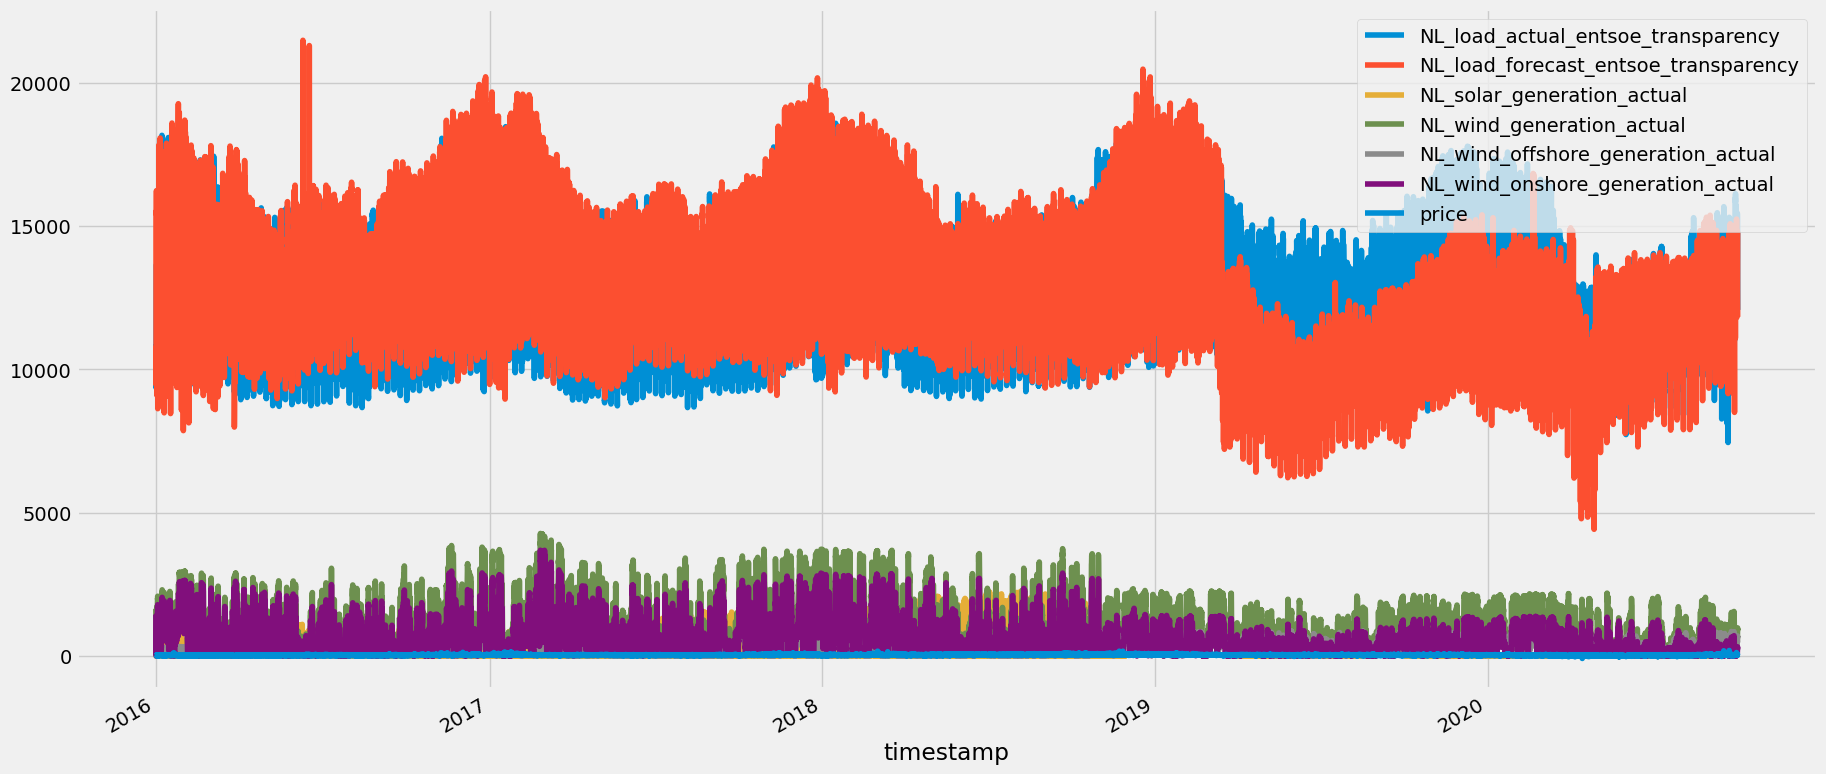

In [6]:
df.plot(figsize = (20,10))

# 2. Modelling XGBoost

## 2.1 Train/Test Split and Cross Validation

In [7]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=4, test_size=24*91*1, gap=24)
df = df.sort_index()

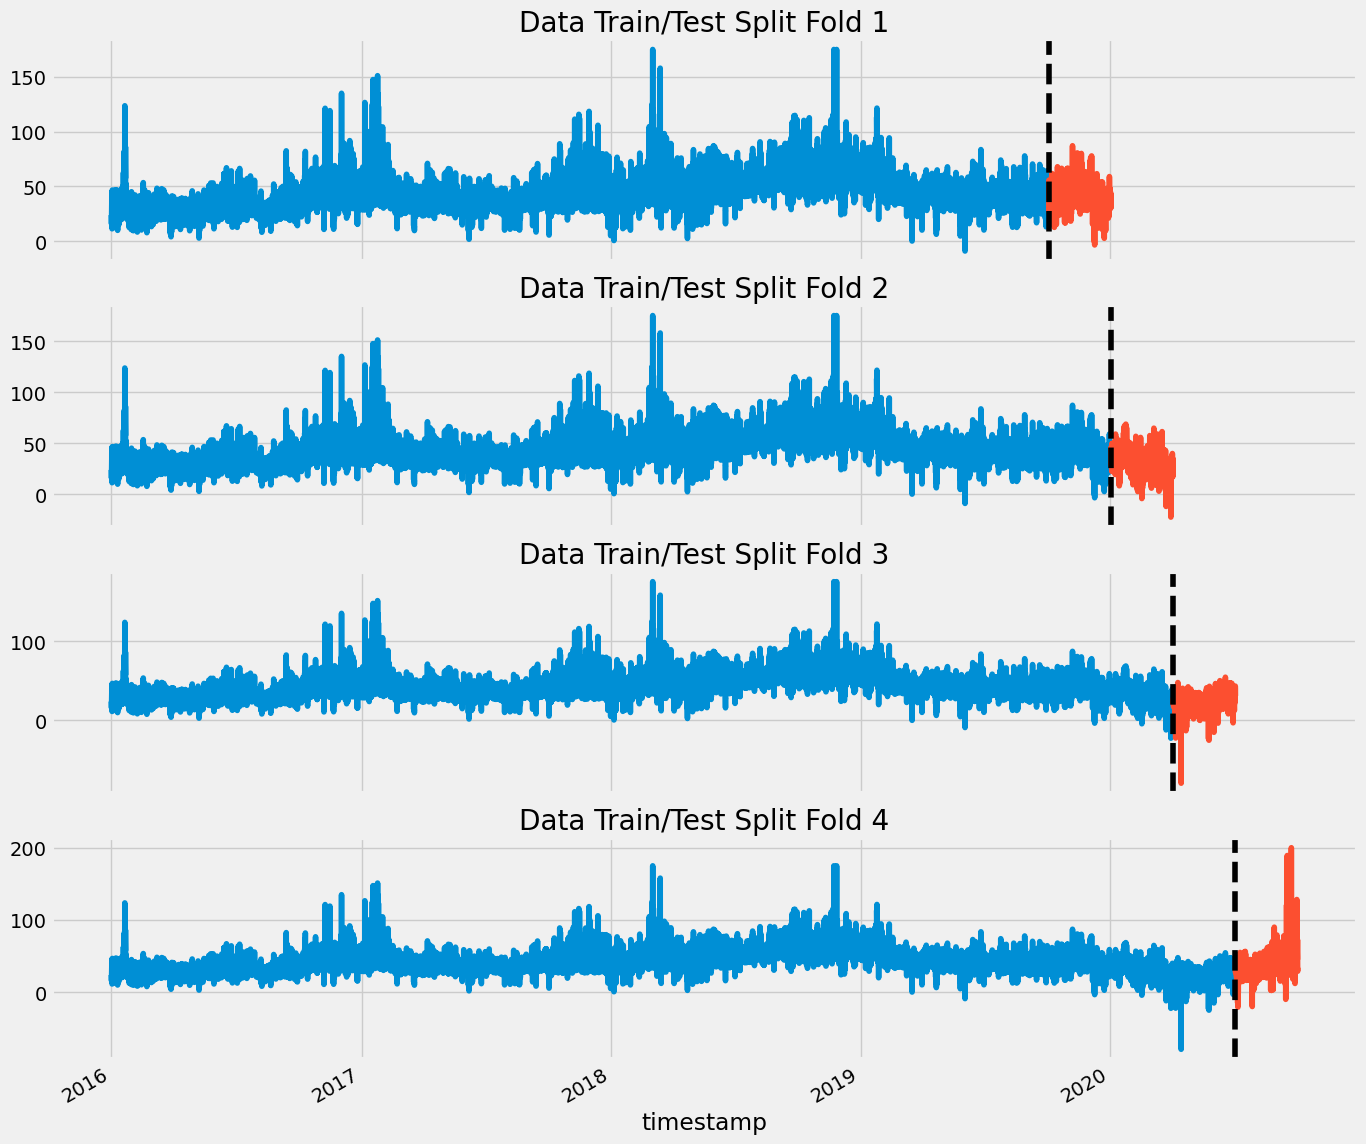

In [8]:
fig, axs = plt.subplots(4, 1, figsize = (15,15), sharex=True)

countr=0
for train_idx, val_idx in tss.split(df):
    train_data = df.iloc[train_idx]
    test_data = df.iloc[val_idx]
    train_data['price'].plot(ax=axs[countr], label='Training Set', title=f'Data Train/Test Split Fold {countr+1}')
    test_data['price'].plot(ax=axs[countr], label='Test Set')
    axs[countr].axvline(test_data.index.min(), color='black', ls='--')
    countr += 1

## 2.2 Adding Lags

In [9]:
def add_lags(df):
    target_map = df['price'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('91 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('182 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('273 days')).map(target_map)
    return df

In [10]:
df = add_lags(df)

In [12]:
# Checking the inclusion point of price lag1 on 2016-04-01 00:00:00 - 91 days after first timestamp of the dataset

df.loc[(df.index>='2016-03-31') & (df.index<'2016-04-30')].head(50)

,NL_load_actual_entsoe_transparency,NL_load_forecast_entsoe_transparency,NL_solar_generation_actual,NL_wind_generation_actual,NL_wind_offshore_generation_actual,NL_wind_onshore_generation_actual,price,lag1,lag2,lag3
timestamp,,,,,,,,,,
2016-03-31 00:00:00,10950.0,12872.0,0.0,73.0,10.0,63.0,23.34,NaN,NaN,NaN
2016-03-31 01:00:00,10269.0,12256.0,0.0,64.0,3.0,61.0,22.27,NaN,NaN,NaN
2016-03-31 02:00:00,9943.0,11962.0,0.0,52.0,0.0,52.0,21.50,NaN,NaN,NaN
2016-03-31 03:00:00,9861.0,11869.0,0.0,37.0,0.0,37.0,21.11,NaN,NaN,NaN
2016-03-31 04:00:00,10040.0,11957.0,0.0,45.0,0.0,45.0,21.29,NaN,NaN,NaN
2016-03-31 05:00:00,10491.0,12412.0,0.0,23.0,0.0,23.0,22.86,NaN,NaN,NaN
2016-03-31 06:00:00,11981.0,13573.0,0.0,4.0,0.0,4.0,29.08,NaN,NaN,NaN
2016-03-31 07:00:00,13932.0,15393.0,6.0,0.0,0.0,0.0,36.09,NaN,NaN,NaN
2016-03-31 08:00:00,15165.0,16952.0,50.0,0.0,0.0,0.0,40.96,NaN,NaN,NaN


## 2.3 Feature Creation

In [13]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

## 2.4 Training and Testing

In [14]:
df.columns

Index(['NL_load_actual_entsoe_transparency',
       'NL_load_forecast_entsoe_transparency', 'NL_solar_generation_actual',
       'NL_wind_generation_actual', 'NL_wind_offshore_generation_actual',
       'NL_wind_onshore_generation_actual', 'price', 'lag1', 'lag2', 'lag3',
       'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')

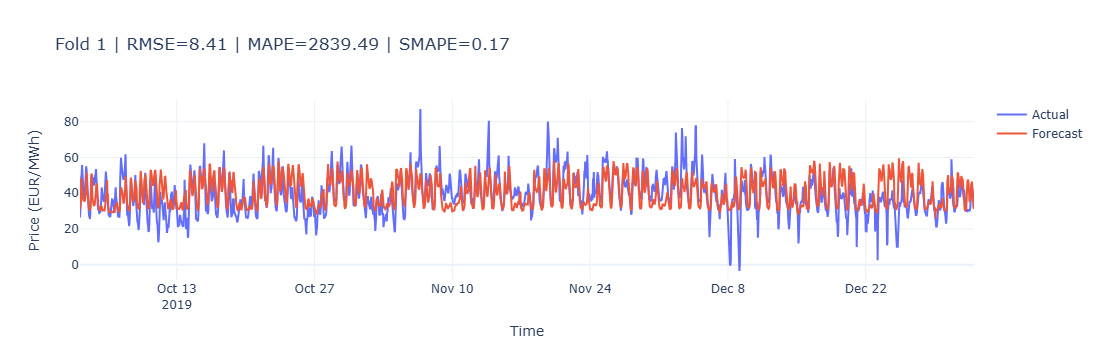

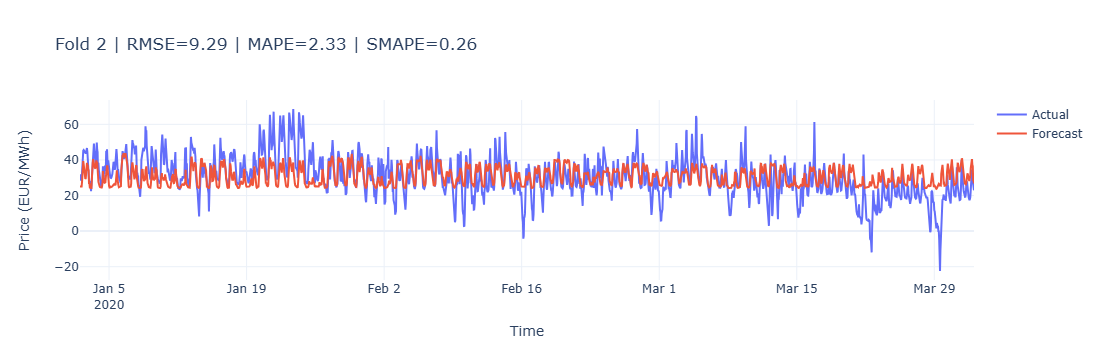

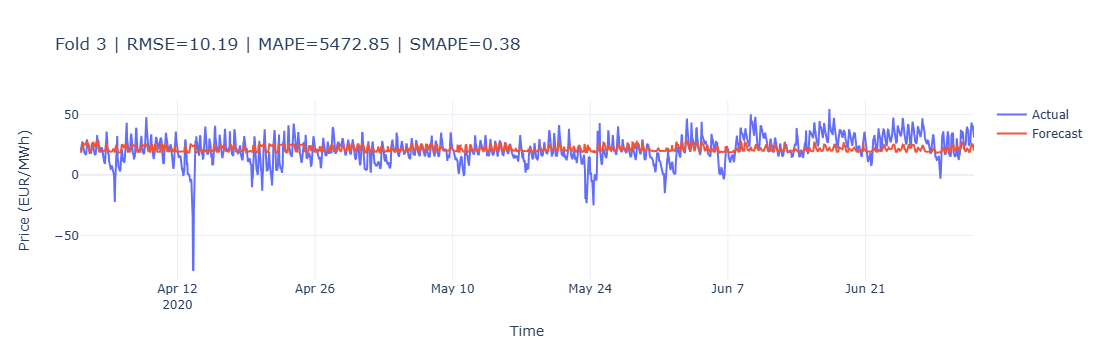

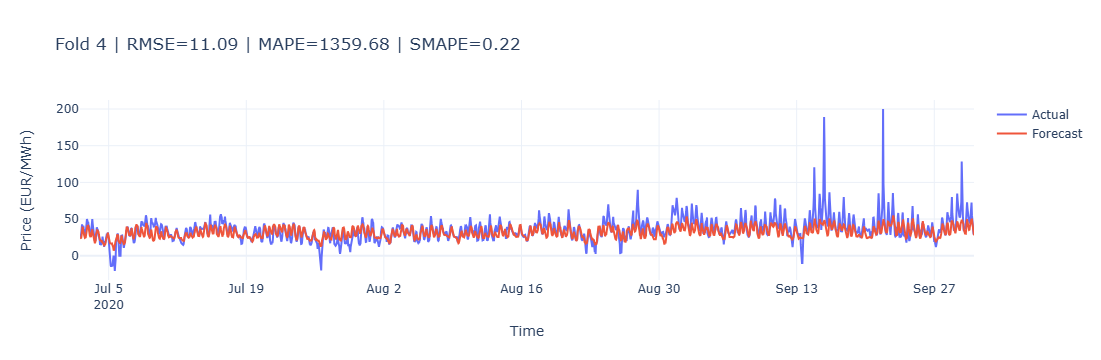

In [18]:
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_percentage_error

# Define SMAPE function
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Clipped MAPE function
def safe_mape(y_true, y_pred, epsilon=1e-5):
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), epsilon)))

# Initialize fold counter, predictions list, and scores list
countr = 0
preds = []
scores = []

# TimeSeriesSplit loop — train/test split across multiple folds
for train_idx, val_idx in tss.split(df):
    # Slice the training and validation sets
    train_data = df.iloc[train_idx]
    test_data = df.iloc[val_idx]

    # Create time-based features for both train and test sets
    train_data = create_features(train_data)
    test_data = create_features(test_data)

    # Feature columns used for training
    feats = [
        'NL_load_forecast_entsoe_transparency', 
        'NL_solar_generation_actual', 
        'NL_wind_offshore_generation_actual', 
        'NL_wind_onshore_generation_actual', 
        'lag1', 'lag2', 'lag3',  # lagged values of target
        'hour', 'dayofweek', 'quarter', 'month', 'year', 
        'dayofyear', 'dayofmonth', 'weekofyear'  # calendar/time features
    ]

    # Target variable
    targ = 'price'

    # Prepare feature matrices and target vectors
    x_train = train_data[feats]
    y_train = train_data[targ]
    x_test = test_data[feats]
    y_test = test_data[targ]

    # Define XGBoost regressor with early stopping
    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.01
    )

    # Train the model with validation set
    reg.fit(
        x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=False
    )

    # Predict on test set and store predictions
    y_pred = pd.Series(reg.predict(x_test), index=x_test.index)
    preds.append(y_pred)

    # Calculate RMSE and store score
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

    # Create interactive plot for actual vs predicted prices
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred, mode='lines', name='Forecast'))

    # Update layout with metrics in the title
    fig.update_layout(
        title=(
            f'Fold {countr+1} | '
            f'RMSE={score:.2f} | '
            f'MAPE={safe_mape(y_test, y_pred):.2f} | '
            f'SMAPE={smape(y_test, y_pred):.2f}'
        ),
        xaxis_title='Time',
        yaxis_title='Price (EUR/MWh)',
        template='plotly_white'
    )

    # Show the plot for this fold
    fig.show()

    # Increment fold counter
    countr += 1